# Table of Contents

* [Chapter 1](#chapter1)
    * [Section 1.1](#section_1_1)
    * [Section 1.2](sSection_1_2)
        * [Section 1.2.1](#section_1_2_1)
        * [Section 1.2.2](#section_1_2_2)
        * [Section 1.2.3](#section_1_2_3)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(
    style="whitegrid",
    font_scale=2
);

# 0. Data loading <a class="anchor" id="section_1"></a>

In [2]:
DATA_FOLDER = Path('./data')
FRAME_LENGTH = 30
classes = [f.name for f in DATA_FOLDER.iterdir()]
classes

['running', 'stairs', 'walking', 'idle']

In [3]:
x_acc_cols = [f'acc_x_{i}' for i in range(FRAME_LENGTH)]
y_acc_cols = [f'acc_y_{i}' for i in range(FRAME_LENGTH)]
z_acc_cols = [f'acc_z_{i}' for i in range(FRAME_LENGTH)]

frames = []
labels = []

for class_name in classes:
    class_folder = DATA_FOLDER / class_name
    for file in class_folder.iterdir():
        df = pd.read_csv(file)
        flat_frame = np.hstack([df['accelerometer_X'], df['accelerometer_Y'], df['accelerometer_Z']]).astype(float)
        frames.append(flat_frame)
        labels.append(class_name)
        
raw_data = pd.DataFrame(frames, columns = x_acc_cols+y_acc_cols+z_acc_cols)
raw_data = pd.concat([raw_data, pd.Series(labels, name='label')], axis=1)
raw_data.head(3)

,acc_x_0,acc_x_1,acc_x_2,acc_x_3,acc_x_4,acc_x_5,acc_x_6,acc_x_7,acc_x_8,acc_x_9,...,acc_z_21,acc_z_22,acc_z_23,acc_z_24,acc_z_25,acc_z_26,acc_z_27,acc_z_28,acc_z_29,label
0,2.667141,4.017470,22.357056,17.922995,-2.164358,9.749189,3.303998,-3.275268,5.252879,21.490355,...,13.493721,-2.001553,16.668432,9.208099,-7.187393,12.430696,-8.939949,1.470040,10.807426,running
1,10.745177,3.744532,0.766145,23.956383,-0.454898,-3.481169,3.572149,7.527370,-10.793061,9.481039,...,11.468226,-0.952892,-0.943315,-0.416591,0.483629,0.363919,1.699883,3.390190,-1.407790,running
2,22.031445,3.600880,-0.354342,8.245631,18.641254,4.381389,26.499025,4.003105,3.284845,2.231396,...,0.565032,-4.079719,-3.677494,4.596867,-0.550666,-6.019023,-1.139640,-2.164358,-3.016694,running


In [4]:
raw_data.shape

(6462, 91)

# 1. EDA

In [5]:
raw_data.label.value_counts()

running    3408
walking    1850
idle       1039
stairs      165
Name: label, dtype: int64

# 2. Setup validation and baselines 

## 2.1 StratifiedKFold

In [6]:
from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [8]:
X = raw_data['acc_x_0']
y = raw_data['label']

for i, (_, valid_ix) in enumerate(kfold.split(X, y)):
    y_valid = y.loc[valid_ix]
    value_counts = y_valid.value_counts()
    print(f'split#{i}, we have {value_counts.stairs} "stairs", {value_counts.running} "running" samples')
#     print(    (y_valid == 'stairs').index)

split#0, we have 33 "stairs", 682 "running" samples
split#1, we have 33 "stairs", 682 "running" samples
split#2, we have 33 "stairs", 682 "running" samples
split#3, we have 33 "stairs", 681 "running" samples
split#4, we have 33 "stairs", 681 "running" samples


In [26]:
mean_x = raw_data[x_acc_cols].mean(axis=1)
mean_y = raw_data[y_acc_cols].mean(axis=1)
mean_z = raw_data[z_acc_cols].mean(axis=1)

In [27]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# target label encoder
target_le = LabelEncoder()
target_le.fit(classes)

LabelEncoder()

In [28]:
simple_features = pd.DataFrame({
    'mean_x': mean_x,
    'mean_y': mean_y,
    'mean_z': mean_z,
    'label': raw_data['label']
})

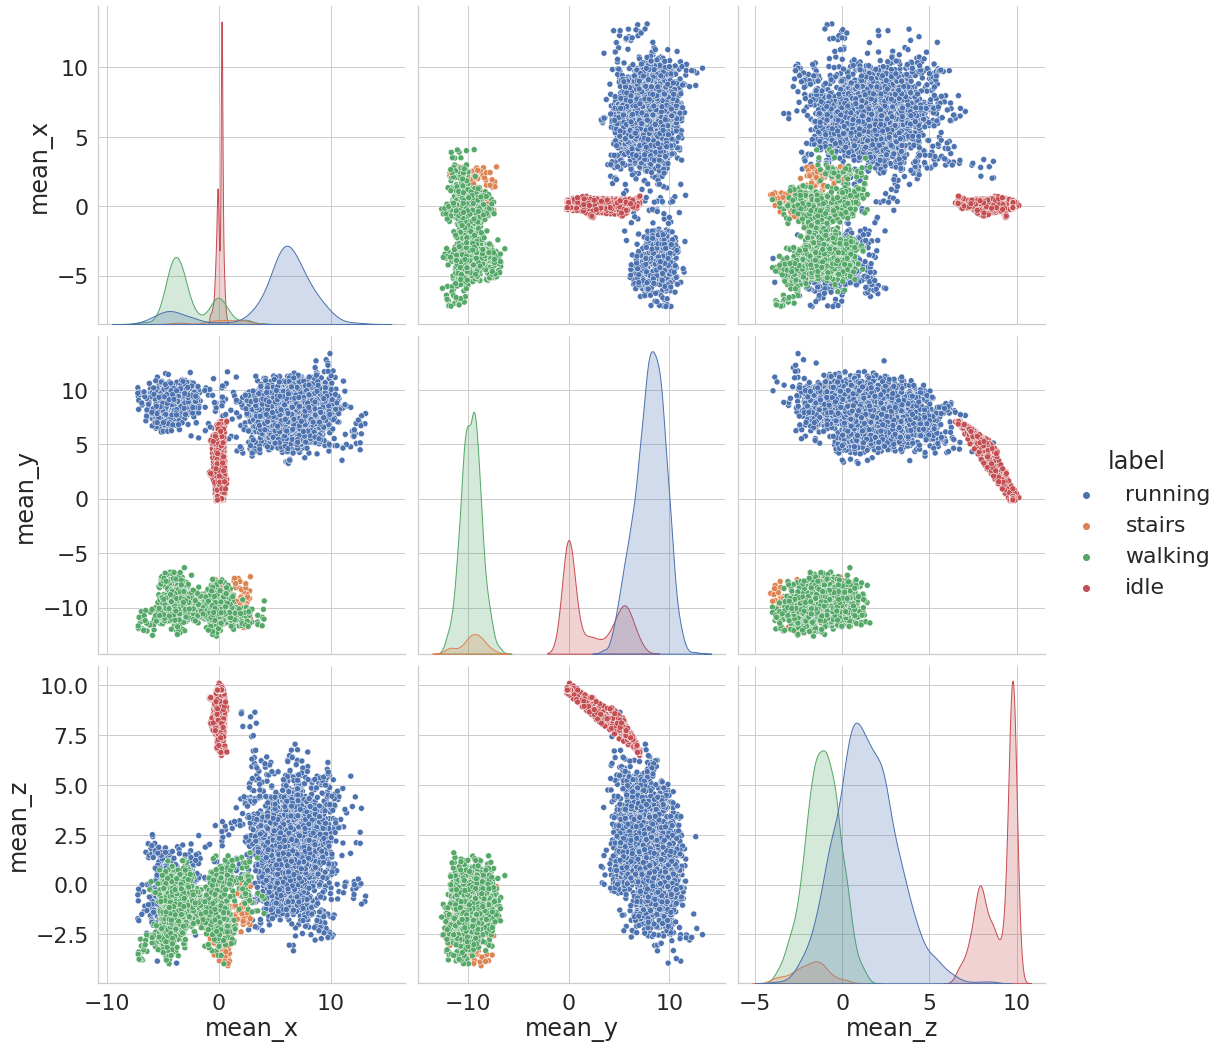

In [29]:
sns.pairplot(data=simple_features, hue='label', height=5);

In [54]:
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import f1_score, confusion_matrix, multilabel_confusion_matrix, accuracy_score
from IPython.display import display, HTML

In [55]:
numerical_metrics = ['accuracy', 'f1_macro', 'f1_min']

def evaluate_performance(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_min': f1_score(y_true, y_pred, average=None).min(),
        'CM': confusion_matrix(y_true, y_pred, normalize='true'),
        'CM_not_normalized': confusion_matrix(y_true, y_pred),
    }
    
    return metrics

def plot_confusion_matrix(df, title=None):
    # C_ij - i is true, predicted in j
    cm = df['CM'].values.mean()
    cm_nn = df['CM_not_normalized'].values.mean()
    cm_print = np.empty_like(cm_nn).astype(str)
    for i in range(4):
        for j in range(4):
            cm_print[i,j] = ("%.2f" % (cm[i,j]*100))+'%\n'+str(cm_nn[i,j])
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.3)
    labels_ordered = target_le.inverse_transform(range(4))
    sns.heatmap(cm,
                annot=cm_print,
                fmt='',
                cmap='Blues',
                cbar=False,
                xticklabels=labels_ordered,
                yticklabels=labels_ordered,
               )
    plt.xlabel('predicted')
    plt.ylabel('actual');
    plt.title(title);
    
def print_cv_metrics(cv_metrics, title=None):
    df = pd.DataFrame(cv_metrics)
    plot_confusion_matrix(df, title=title);
    plt.show()
    print_df = pd.concat([df.mean()[numerical_metrics], df.std()[numerical_metrics]], axis=1)
    print_df.columns = ['mean', 'std']
    display(HTML(print_df.T.to_html()))    
    

[[208   0   0   0]
 [  4 678   0   0]
 [  0   0  11  22]
 [  0   0   3 367]]
[[208   0   0   0]
 [  2 680   0   0]
 [  0   0   8  25]
 [  0   0   1 369]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  11  22]
 [  0   0   1 369]]
[[208   0   0   0]
 [  3 678   0   0]
 [  0   0  10  23]
 [  0   0   9 361]]
[[208   0   0   0]
 [  1 680   0   0]
 [  0   0  13  20]
 [  0   0   7 363]]


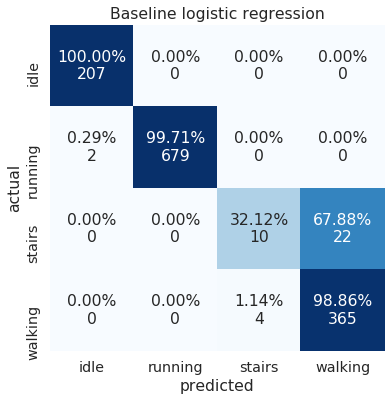

,accuracy,f1_macro,f1_min
mean,0.977871,0.85032,0.442622
std,0.00331122,0.0151261,0.0553524


In [56]:
X = simple_features[['mean_x', 'mean_y', 'mean_z']]
y = simple_features['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    cls = linear_model.LogisticRegression()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics, 'Baseline logistic regression')

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  19  14]
 [  0   0   3 367]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  15  18]
 [  0   0   3 367]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  19  14]
 [  0   0   2 368]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  18  15]
 [  0   0   2 368]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  19  14]
 [  0   0   4 366]]


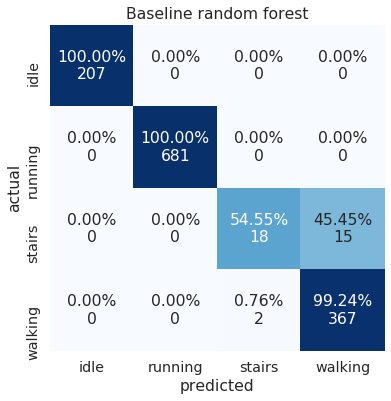

,accuracy,f1_macro,f1_min
mean,0.986227,0.911118,0.668133
std,0.00148464,0.0120691,0.0458261


In [57]:
X = simple_features[['mean_x', 'mean_y', 'mean_z']]
y = simple_features['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_valid = scaler.transform(X_valid)
    
    cls = RandomForestClassifier()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics, 'Baseline random forest')

# 3. Feature engineering

# 4. Modeling

## Logistic regression

### Adding polynomial features

### Feature selection with Lasso

### Final model

## RandomForest